# IMPORTS

In [1]:
import time
import numpy as np
import pandas as pd
from collections import Counter
from transformers import pipeline
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import faiss
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
FILE_PATH = "data/musteriyorumlari.xlsx"

df = pd.read_excel(FILE_PATH)
df.columns = df.columns.str.strip()

# Sadece gerekli sütunlar
df = df[['Score', 'Feedback']].dropna().reset_index().rename(columns={"index":"original_id"})

feedback_list = df["Feedback"].astype(str).tolist()
print(f"Toplam yorum sayısı: {len(feedback_list)}")

Toplam yorum sayısı: 50000


# NON RAG

In [3]:
#  Türkçe kelime arama için normalize fonksiyonu.
def normalize_text(text):
    """
    Türkçe karakterleri normalize eder, aksanları kaldırır, büyük/küçük harf duyarsız hale getirir.
    """
    if not isinstance(text, str):
        return ""

    # Unicode Normalization
    text = unicodedata.normalize("NFD", text)
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")

    text = text.lower() # lowercase

    # Türkçe harf dönüşümleri
    text = (
        text.replace("ı", "i")
            .replace("İ", "i")
            .replace("ğ", "g")
            .replace("Ğ", "g")
            .replace("ü", "u")
            .replace("Ü", "u")
            .replace("ş", "s")
            .replace("Ş", "s")
            .replace("ö", "o")
            .replace("Ö", "o")
            .replace("ç", "c")
            .replace("Ç", "c")
    )

    # Noktalama kaldır
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [4]:
# Feedback list onceden normalize edelim.
start_norm = time.time()
feedback_norm = [normalize_text(c) for c in feedback_list]
end_norm = time.time()
print(f"Normalize işlemi tamamlandı: {end_norm - start_norm:.2f} saniye")

Normalize işlemi tamamlandı: 0.26 saniye


In [5]:
#  NON-RAG Search yapısı
def non_rag_search(query):
    """
    normalize_text tabanlı Non-RAG keyword search.
    """
    print(f"\n--- Non-RAG Keyword Search ---")
    print(f"Sorgu: '{query}'")

    start_time = time.time()

    q_norm = normalize_text(query)

    matched = [
        orig
        for orig, norm in zip(feedback_list, feedback_norm)
        if q_norm in norm
    ]

    end_time = time.time()

    print(f"Arama süresi: {end_time - start_time:.4f} saniye")
    print(f"Bulunan yorum sayısı: {len(matched)}")

    return matched

In [6]:
#  BERT kullanrak sentiment analiz
MODEL_NAME = "savasy/bert-base-turkish-sentiment-cased"

print(f"\nSentiment Analiz modeli yükleniyor: {MODEL_NAME}")
start_model_load = time.time()
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=MODEL_NAME,
    tokenizer=MODEL_NAME,
    device=0                # GPU = 0
)
end_model_load = time.time()
print(f"Model yükleme süresi: {end_model_load - start_model_load:.2f} saniye")


Sentiment Analiz modeli yükleniyor: savasy/bert-base-turkish-sentiment-cased


Device set to use mps:0


Model yükleme süresi: 0.89 saniye


In [7]:
# Sentiment Analiz ve Summary oluşturma (batch_size kullanarak)
def analyze_sentiments(comments, pipeline_model, batch_size=64):
    """
    Verilen yorumlar için sentiment analizi yapar.
    """
    if not comments:
        print("Analiz edilecek yorum yok.")
        return

    print(f"\n{len(comments)} yorum analiz ediliyor (batch_size={batch_size})")

    start_time = time.time()
    results = pipeline_model(comments, batch_size=batch_size, truncation=True)
    end_time = time.time()

    print(f"Duygu analizi süresi: {end_time - start_time:.2f} saniye")

    # Label'dan numeric skora
    label_to_score = {"positive": 1, "neutral": 0, "negative": -1}

    labels = []
    scores = []

    for sentiment in results:
        label = sentiment["label"].lower()
        labels.append(label)
        scores.append(label_to_score.get(label, 0))

    # Summary
    print("\n### Non-RAG Sentiment Summary ###")
    total = len(labels)
    counts = Counter(labels)

    print(f"Toplam analiz edilen yorum: {total}")
    print(f"  Pozitif: {counts.get('positive', 0)} (%{counts.get('positive', 0)/total:.2%})")
    print(f"  Negatif: {counts.get('negative', 0)} (%{counts.get('negative', 0)/total:.2%})")
    print(f"  Nötr:    {counts.get('neutral', 0)}  (%{counts.get('neutral', 0)/total:.2%})")

    print(f"\nOrtalama Sayısal Skor: {np.mean(scores):.3f} (1=Pozitif, 0=Nötr, -1=Negatif)")

In [8]:
# Oluşturduğumuz pipeline'ı test edelim.
TEST_QUERY = "kredi"        # denemek istedigin degeri gir.
matched_comments = non_rag_search(TEST_QUERY)
analyze_sentiments(matched_comments, sentiment_pipeline, batch_size=64)


--- Non-RAG Keyword Search ---
Sorgu: 'kredi'
Arama süresi: 0.0046 saniye
Bulunan yorum sayısı: 25032

25032 yorum analiz ediliyor (batch_size=64)
Duygu analizi süresi: 22.74 saniye

### Non-RAG Sentiment Summary ###
Toplam analiz edilen yorum: 25032
  Pozitif: 7815 (%31.22%)
  Negatif: 17217 (%68.78%)
  Nötr:    0  (%0.00%)

Ortalama Sayısal Skor: -0.376 (1=Pozitif, 0=Nötr, -1=Negatif)


In [12]:
TEST_QUERY = "rezalet"

matched_comments = non_rag_search(TEST_QUERY)
analyze_sentiments(matched_comments, sentiment_pipeline, batch_size=64)


--- Non-RAG Keyword Search ---
Sorgu: 'rezalet'
Arama süresi: 0.0037 saniye
Bulunan yorum sayısı: 0
Analiz edilecek yorum yok.


In [9]:
TEST_QUERY = "finansman"

matched_comments = non_rag_search(TEST_QUERY)
analyze_sentiments(matched_comments, sentiment_pipeline, batch_size=64)


--- Non-RAG Keyword Search ---
Sorgu: 'finansman'
Arama süresi: 0.0035 saniye
Bulunan yorum sayısı: 0
Analiz edilecek yorum yok.


**NON-RAG**:

Kullanıcıdan gelen sorgu (keyword) doğrudan tüm yorumlar içinde string match yöntemiyle aranır. İçerisinde ilgili kelimeyi (kelimeleri) içeren yorumları alır ve bunun üzerinden çalışır. Bu nedenle girdiğimiz her kelimenin (kelimelerin) karşılığı olmayabilir, yani anlam aramıyor doğrudan match bakıyor (eş anlam yapısı da anlayamaz). Tek tek tüm yorumlarda gezdiği için veri seti büyüdükçe hesaplama maliyeti de problem olmaya başlar.

## NON-RAG yapisinin saglamligi icin deneme

In [11]:
test_queries = [
    "KREDİ",
    "KrEdİ",
    "kredi",
    "kredî",
    "kredí",
    "K R E D İ",
    "faiz",
    "FAİZ",
    "FaiZ",
]

print("### Türkçe karakterlere ve Büyük Küçük Harflere duyarlılık testi ###\n")

for q in test_queries:
    matched = non_rag_search(q)
    print(f"{q:<15} → {len(matched)} yorum bulundu")

### Türkçe karakterlere ve Büyük Küçük Harflere duyarlılık testi ###


--- Non-RAG Keyword Search ---
Sorgu: 'KREDİ'
Arama süresi: 0.0032 saniye
Bulunan yorum sayısı: 25032
KREDİ           → 25032 yorum bulundu

--- Non-RAG Keyword Search ---
Sorgu: 'KrEdİ'
Arama süresi: 0.0032 saniye
Bulunan yorum sayısı: 25032
KrEdİ           → 25032 yorum bulundu

--- Non-RAG Keyword Search ---
Sorgu: 'kredi'
Arama süresi: 0.0035 saniye
Bulunan yorum sayısı: 25032
kredi           → 25032 yorum bulundu

--- Non-RAG Keyword Search ---
Sorgu: 'kredî'
Arama süresi: 0.0033 saniye
Bulunan yorum sayısı: 25032
kredî           → 25032 yorum bulundu

--- Non-RAG Keyword Search ---
Sorgu: 'kredí'
Arama süresi: 0.0032 saniye
Bulunan yorum sayısı: 25032
kredí           → 25032 yorum bulundu

--- Non-RAG Keyword Search ---
Sorgu: 'K R E D İ'
Arama süresi: 0.0027 saniye
Bulunan yorum sayısı: 0
K R E D İ       → 0 yorum bulundu

--- Non-RAG Keyword Search ---
Sorgu: 'faiz'
Arama süresi: 0.0028 saniye
Bulunan yorum 

In [12]:
synonym_tests = {
    "kredi": ["finansman", "borç", "nakit", "limit", "kart limiti"],
    "faiz": ["oran", "oranı", "APR", "maliyet"],
    "destek": ["yardım", "müşteri hizmetleri", "call center", "çözüm"],
}

print("### Eş anlam, ve Anlam Tespit testi ###\n")

for key, synonyms in synonym_tests.items():
    print(f"\n---- '{key.upper()}' için eş anlam testleri ----")
    base_count = len(non_rag_search(key))
    print(f"'{key}' → {base_count} yorum")
    
    for syn in synonyms:
        syn_count = len(non_rag_search(syn))
        print(f"  '{syn}' {syn_count} yorum")

### Eş anlam, ve Anlam Tespit testi ###


---- 'KREDI' için eş anlam testleri ----

--- Non-RAG Keyword Search ---
Sorgu: 'kredi'
Arama süresi: 0.0032 saniye
Bulunan yorum sayısı: 25032
'kredi' → 25032 yorum

--- Non-RAG Keyword Search ---
Sorgu: 'finansman'
Arama süresi: 0.0027 saniye
Bulunan yorum sayısı: 0
  'finansman' 0 yorum

--- Non-RAG Keyword Search ---
Sorgu: 'borç'
Arama süresi: 0.0024 saniye
Bulunan yorum sayısı: 0
  'borç' 0 yorum

--- Non-RAG Keyword Search ---
Sorgu: 'nakit'
Arama süresi: 0.0026 saniye
Bulunan yorum sayısı: 0
  'nakit' 0 yorum

--- Non-RAG Keyword Search ---
Sorgu: 'limit'
Arama süresi: 0.0024 saniye
Bulunan yorum sayısı: 1596
  'limit' 1596 yorum

--- Non-RAG Keyword Search ---
Sorgu: 'kart limiti'
Arama süresi: 0.0023 saniye
Bulunan yorum sayısı: 0
  'kart limiti' 0 yorum

---- 'FAIZ' için eş anlam testleri ----

--- Non-RAG Keyword Search ---
Sorgu: 'faiz'
Arama süresi: 0.0025 saniye
Bulunan yorum sayısı: 1544
'faiz' → 1544 yorum

--- Non-RAG Keyword 

NON-REG yapımız Türkçe karakter, büyük küçük harf testinden geçse de anlama dayalı arama kısmında noksandır.

# RAG Yapısı

In [13]:
df = pd.read_excel("data/musteriyorumlari.xlsx")
df.head()

,ID,Score,Title,Feedback,Timestamp
0,1,3,Araç Bulunurluğu Yorumu,Araç stokları çok sınırlıydı.,2025-10-22 13:07:09
1,2,4,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09
2,3,3,Destek Ekibi Yorumu,Destek ekibi beklediğimden iyiydi.,2025-10-22 13:07:09
3,4,3,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09
4,5,5,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09


Verisetini incelediğimde toplam 50.000 yorumun yalnızca 32 unique feedback cümlesinden oluştuğunu keşfettim. Bu nedenle, tüm yorumları işlemek yerine yalnızca bu 32 benzersiz cümleyi template olarak kullanan bir yapı kurdum.

Bu yaklaşım RAG mimaride büyük bir performans kazancı sağladı çünkü:
- Tüm yorumları gezmek yerine sadece 32 embedding’e bakılıyor
- Sentiment her yorum için değil, sadece template için bir kez hesaplanıyor
- Sorgu anında sentiment modeli çalışmıyor
- Sistem çok düşük kaynakta bile yüksek hızda cevap verebiliyor.

In [15]:
print("Toplam satır sayısı:", len(df))

df_templates = (
    df.groupby(["Title", "Feedback"])
      .agg(
          count=("Feedback", "size"),
          avg_score=("Score", "mean")
      )
      .reset_index()
)

df_templates["template_id"] = df_templates.index 

print("Template tablosu yeniden oluşturuldu")
print("Benzersiz template sayısı:", len(df_templates))

print("\nİlk 10 template:")
print(df_templates.head(10))

Toplam satır sayısı: 50000
Template tablosu yeniden oluşturuldu
Benzersiz template sayısı: 32

İlk 10 template:
                     Title                                 Feedback  count  \
0  Araç Bulunurluğu Yorumu         Aradığım aracı hemen bulabildim.   1606   
1  Araç Bulunurluğu Yorumu           Araç bulmakta hiç zorlanmadım.   1568   
2  Araç Bulunurluğu Yorumu  Araç bulunurluğu beklediğimden kötüydü.   1593   
3  Araç Bulunurluğu Yorumu                 Araç bulunurluğu iyiydi.   1529   
4  Araç Bulunurluğu Yorumu               Araç seçenekleri fazlaydı.   1521   
5  Araç Bulunurluğu Yorumu            Araç stokları çok sınırlıydı.   1532   
6  Araç Bulunurluğu Yorumu        Araç teslimatı hızlı gerçekleşti.   1598   
7  Araç Bulunurluğu Yorumu          İstediğim model mevcut değildi.   1593   
8      Destek Ekibi Yorumu       Destek ekibi beklediğimden iyiydi.   1531   
9      Destek Ekibi Yorumu              Destek ekibi profesyoneldi.   1591   

   avg_score  template_id  
0

In [16]:
df_merged = df.merge(
    df_templates[["Title", "Feedback", "template_id", "count", "avg_score"]],
    on=["Title", "Feedback"],
    how="left"
)

print(df_merged.head())
print("Eksik template ID:", df_merged["template_id"].isna().sum())

   ID  Score                    Title  \
0   1      3  Araç Bulunurluğu Yorumu   
1   2      4      Destek Ekibi Yorumu   
2   3      3      Destek Ekibi Yorumu   
3   4      3  Araç Bulunurluğu Yorumu   
4   5      5      Destek Ekibi Yorumu   

                                  Feedback            Timestamp  template_id  \
0            Araç stokları çok sınırlıydı.  2025-10-22 13:07:09            5   
1           Destek ekibi ulaşılması zordu.  2025-10-22 13:07:09           13   
2       Destek ekibi beklediğimden iyiydi.  2025-10-22 13:07:09            8   
3  Araç bulunurluğu beklediğimden kötüydü.  2025-10-22 13:07:09            2   
4           Destek ekibi ulaşılması zordu.  2025-10-22 13:07:09           13   

   count  avg_score  
0   1532   2.978460  
1   1484   2.979784  
2   1531   3.034618  
3   1593   2.996861  
4   1484   2.979784  
Eksik template ID: 0


In [17]:
print("Embedding modeli yükleniyor")
embed_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
print("Model yüklendi")

# Template Embedding
template_texts = df_templates["Feedback"].tolist()
start = time.time()
template_embeddings = embed_model.encode(template_texts, show_progress_bar=True)
end = time.time()

print("Embedding süresi:", round(end - start, 2), "saniye")
print("Embedding shape:", template_embeddings.shape)

# FAISS Index
dim = template_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)

# Cosine similarity için normalize edelim.
template_embeddings_norm = template_embeddings / np.linalg.norm(template_embeddings, axis=1, keepdims=True)
index.add(template_embeddings_norm)

print("FAISS index'e eklenen vektör sayısı:", index.ntotal)

Embedding modeli yükleniyor
Model yüklendi


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding süresi: 0.09 saniye
Embedding shape: (32, 384)
FAISS index'e eklenen vektör sayısı: 32


In [ ]:
# Template Sentiment Hazirligi
print("Sentiment modeli yükleniyor...")
sentiment_model = pipeline(
    "sentiment-analysis",
    model="savasy/bert-base-turkish-sentiment-cased",
    tokenizer="savasy/bert-base-turkish-sentiment-cased",
    device=0
)
print("Model yüklendi.")

# Template-level analiz
template_texts = df_templates["Feedback"].tolist()

print("32 template için sentiment hesaplanıyor...")
start = time.time()
sentiment_results = sentiment_model(template_texts, batch_size=32, truncation=True)
end = time.time()

print(f"Tamamlandı! Süre: {end:.3f} sn")

# Label'dan skora
label_to_score = {"positive": 1, "neutral": 0, "negative": -1}
template_scores = [label_to_score[r["label"].lower()] for r in sentiment_results]

# sentiment skoru veri setine ekle
df_templates["sentiment_label"] = [r["label"] for r in sentiment_results]
df_templates["sentiment_score"] = template_scores

df_templates.head()

Sentiment modeli yükleniyor...


Device set to use mps:0


Model yüklendi.
32 template için sentiment hesaplanıyor...
Tamamlandı! Süre: 1763247862.543 sn


,Title,Feedback,count,avg_score,template_id,sentiment_label,sentiment_score
0,Araç Bulunurluğu Yorumu,Aradığım aracı hemen bulabildim.,1606,2.894770,0,positive,1
1,Araç Bulunurluğu Yorumu,Araç bulmakta hiç zorlanmadım.,1568,3.009566,1,negative,-1
2,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,1593,2.996861,2,negative,-1
3,Araç Bulunurluğu Yorumu,Araç bulunurluğu iyiydi.,1529,3.012426,3,negative,-1
4,Araç Bulunurluğu Yorumu,Araç seçenekleri fazlaydı.,1521,3.049967,4,negative,-1


Mevcut sentiment modeli Twitter verisine göre eğitildiği için domain’e tam uyum sağlamadı.
Bu nedenle bazı yorumları yanlış sınıflandırıyor.

Bu problemin çözümü için:
1- Domain’e daha uygun modeller (BERTurk, Turkish RoBERTa, Electra) tercih edilebilir.
2- 32 template üzerinden küçük bir fine-tuning seti oluşturup Türkçe modelleri domain’e göre yeniden eğitmek mümkün.

Bu şekilde sentiment kalitesini belirgin şekilde artırabiliceğimizi düşünüyorum.

In [ ]:
def rag_search(query, top_k=5):
    print(f"\n--- RAG Search ---")
    print(f"Sorgu: '{query}' (top_k={top_k})")

    q_emb = embed_model.encode([query])
    q_emb = q_emb / np.linalg.norm(q_emb, axis=1, keepdims=True)

    D, I = index.search(q_emb, top_k)

    for score, idx in zip(D[0], I[0]):
        text = df_templates.loc[idx, "Feedback"]
        print(f"[{score:.3f}] {text}  (template_id={idx})")

    return I[0]

def get_comments_by_template_ids(template_ids):
    return df_merged[df_merged["template_id"].isin(template_ids)]

def rag_sentiment_fast(template_ids):
    subset = df_templates[df_templates["template_id"].isin(template_ids)]

    total_comments = subset["count"].sum()

    weighted_sentiment = np.sum(subset["sentiment_score"] * subset["count"]) / total_comments

    print("\n--- SENTIMENT ---")
    print(f"Template sayısı: {len(subset)}")
    print(f"Toplam yorum: {total_comments}")
    print(f"Ağırlıklı Ortalama Sentiment Skoru: {weighted_sentiment:.3f}")
    
    return weighted_sentiment

def rag_pipeline_fast(query, top_k=5):
    print(f"\n=== RAG PIPELINE — '{query}' ===")
    
    # Template arama
    template_ids = rag_search(query, top_k=top_k)
    
    # Weighted sentiment
    sentiment_score = rag_sentiment_fast(template_ids)

    return sentiment_score

In [22]:
rag_search("kredi", top_k=5)


--- RAG Search ---
Sorgu: 'kredi' (top_k=5)
[0.675] Kredi vadesi esnek seçenekler sundu.  (template_id=22)
[0.647] Krediye ulaşma süreci karmaşıktı.  (template_id=24)
[0.641] Kredi süreci çok uzadı.  (template_id=21)
[0.618] Krediye ulaşmak için şubeye gitmem gerekti.  (template_id=30)
[0.581] Kredi limitim beklentimi karşıladı.  (template_id=20)


array([22, 24, 21, 30, 20])

In [26]:
rag_pipeline_fast("kredi", top_k=5)


=== RAG PIPELINE — 'kredi' ===

--- RAG Search ---
Sorgu: 'kredi' (top_k=5)
[0.675] Kredi vadesi esnek seçenekler sundu.  (template_id=22)
[0.647] Krediye ulaşma süreci karmaşıktı.  (template_id=24)
[0.641] Kredi süreci çok uzadı.  (template_id=21)
[0.618] Krediye ulaşmak için şubeye gitmem gerekti.  (template_id=30)
[0.581] Kredi limitim beklentimi karşıladı.  (template_id=20)

--- SENTIMENT ---
Template sayısı: 5
Toplam yorum: 7894
Ağırlıklı Ortalama Sentiment Skoru: -0.602


np.float64(-0.6022295414238662)

In [27]:
rag_pipeline_fast("Destek ekibi sorunumu çözdü", top_k=5)


=== RAG PIPELINE — 'Destek ekibi sorunumu çözdü' ===

--- RAG Search ---
Sorgu: 'Destek ekibi sorunumu çözdü' (top_k=5)
[0.973] Destek ekibi sorunumu çözdü.  (template_id=10)
[0.621] Destek ekibi çok ilgiliydi.  (template_id=15)
[0.593] Destek ekibi beklediğimden iyiydi.  (template_id=8)
[0.587] Destek ekibi ulaşılması zordu.  (template_id=13)
[0.585] Destek ekibi tüm sorularımı yanıtladı.  (template_id=12)

--- SENTIMENT ---
Template sayısı: 5
Toplam yorum: 7684
Ağırlıklı Ortalama Sentiment Skoru: -0.183


np.float64(-0.18323789692868298)

In [30]:
# Sanirim veri setindeki scorelar noisy bir yapiya sahip.
# Olumlu yorum icin de olumsuz yorum icin de dagilimlar ayni gibi.

print(df[df['Feedback'] == 'Destek ekibi çok ilgiliydi.']['Score'].describe())
print(df[df['Feedback'] == 'Araç stokları çok sınırlıydı.']['Score'].describe())

count    1561.00000
mean        2.94811
std         1.40849
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         5.00000
Name: Score, dtype: float64
count    1532.000000
mean        2.978460
std         1.421191
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Score, dtype: float64


# RAG vs NON-RAG

In [41]:
TEST_QUERY = "berbat"
matched_comments = non_rag_search(TEST_QUERY)
analyze_sentiments(matched_comments, sentiment_pipeline, batch_size=64)


--- Non-RAG Keyword Search ---
Sorgu: 'berbat'
Arama süresi: 0.0037 saniye
Bulunan yorum sayısı: 0
Analiz edilecek yorum yok.


In [42]:
rag_pipeline_fast("berbat", top_k=5)


=== RAG PIPELINE (FAST) — 'berbat' ===

--- RAG Search ---
Sorgu: 'berbat' (top_k=5)
[0.239] Araç bulunurluğu iyiydi.  (template_id=3)
[0.239] Araç bulunurluğu beklediğimden kötüydü.  (template_id=2)
[0.201] Destek ekibi ulaşılması zordu.  (template_id=13)
[0.188] Destek ekibi sorunumu çözdü.  (template_id=10)
[0.156] Aradığım aracı hemen bulabildim.  (template_id=0)

--- FAST SENTIMENT (Template-Level) ---
Template sayısı: 5
Toplam yorum: 7743
Ağırlıklı Ortalama Sentiment Skoru: -0.585


np.float64(-0.5851737052821904)

# RAG İLE ELDE EDİLEN ÇIKARIMLAR

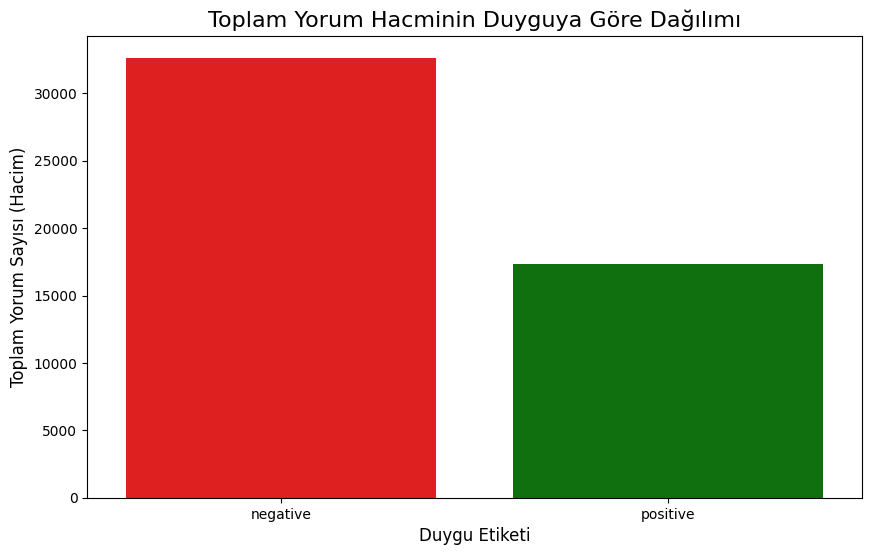

In [32]:
# Duygu bazlı dağılım
df_volume = df_templates.groupby('sentiment_label')['count'].sum().reset_index()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_volume,
    x='sentiment_label',
    y='count',
    palette={"positive": "g", "negative": "r", "neutral": "b"}
)

plt.title('Toplam Yorum Hacminin Duyguya Göre Dağılımı', fontsize=16)
plt.xlabel('Duygu Etiketi', fontsize=12)
plt.ylabel('Toplam Yorum Sayısı (Hacim)', fontsize=12)
plt.show()

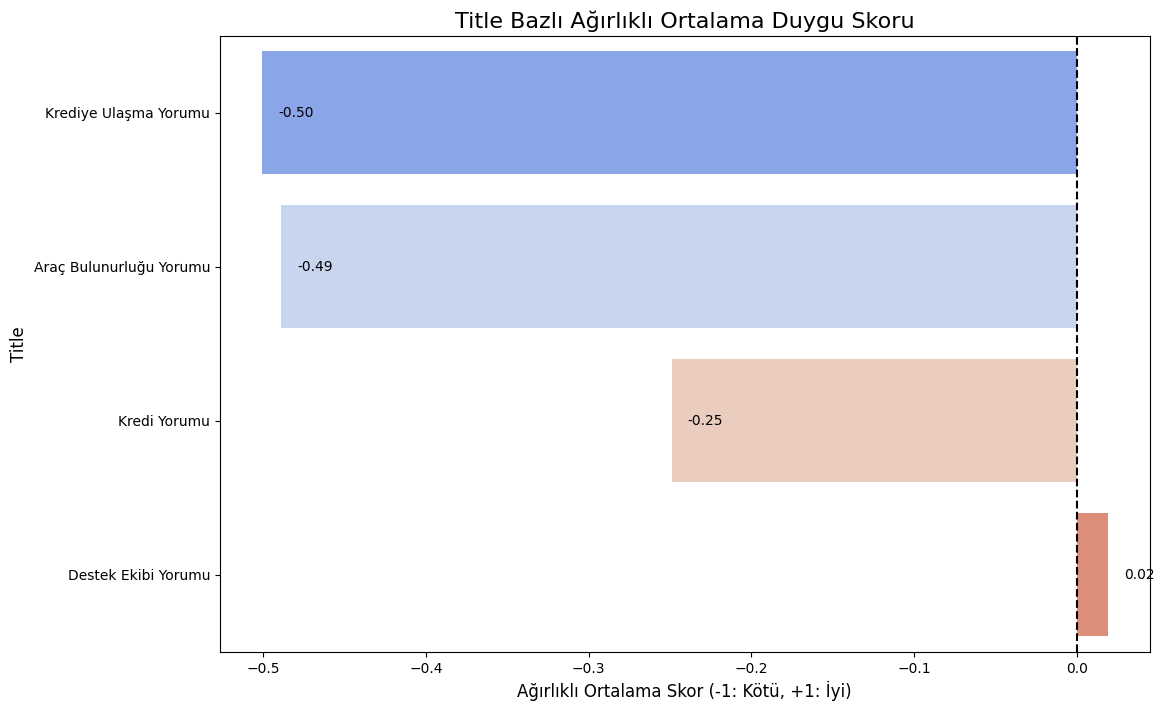

In [33]:
# Title bazında Ağırlıklı Ortalama Sentiment hesapla
def get_weighted_sentiment(group):
    # (skor * hacim) / toplam hacim
    return np.average(group['sentiment_score'], weights=group['count'])

df_topic_sentiment = df_templates.groupby('Title').apply(get_weighted_sentiment)
df_topic_sentiment = df_topic_sentiment.to_frame('weighted_sentiment').sort_values('weighted_sentiment')

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_topic_sentiment,
    x='weighted_sentiment',
    y=df_topic_sentiment.index,
    palette='coolwarm' # Kırmızı (negatif) - Mavi (pozitif)
)

plt.title('Title Bazlı Ağırlıklı Ortalama Duygu Skoru', fontsize=16)
plt.xlabel('Ağırlıklı Ortalama Skor (-1: Kötü, +1: İyi)', fontsize=12)
plt.ylabel('Title', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')

# Barlarin uzerine sayilari yazdiralim.
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.01,
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}', 
             va='center')

plt.show()

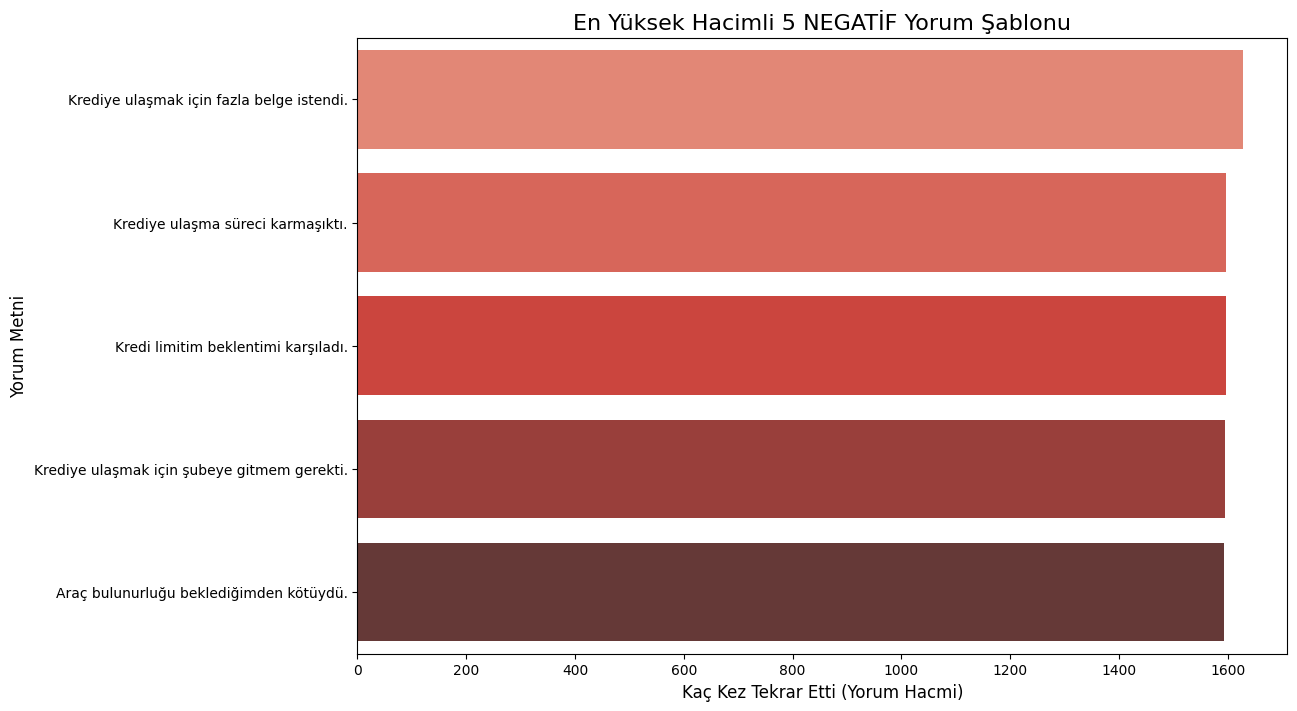

In [34]:
# Sadece negatif şablonları al ve count göre sırala
df_top_negative = df_templates[
    df_templates['sentiment_label'] == 'negative'
].sort_values('count', ascending=False).head(5)     # En çok tekrar eden X = 5

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_top_negative,
    x='count',
    y='Feedback',
    palette='Reds_d'
)

plt.title('En Yüksek Hacimli 5 NEGATİF Yorum Şablonu', fontsize=16)
plt.xlabel('Kaç Kez Tekrar Etti (Yorum Hacmi)', fontsize=12)
plt.ylabel('Yorum Metni', fontsize=12)
plt.show()

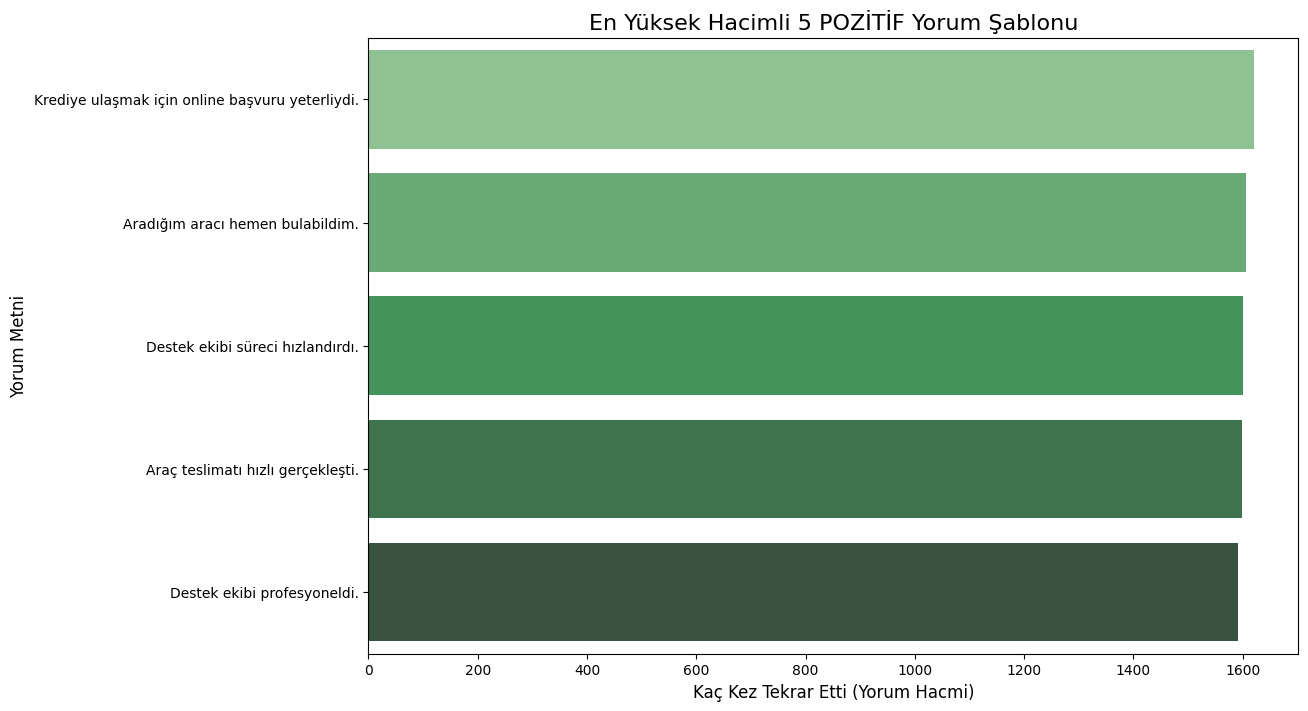

In [35]:
# Sadece POZİTİF şablonları al ve count göre sırala
df_top_positive = df_templates[
    df_templates['sentiment_label'] == 'positive'
].sort_values('count', ascending=False).head(5)     # En çok tekrar eden X =5

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_top_positive,
    x='count',
    y='Feedback',
    palette='Greens_d' # Pozitif için yeşil tonları
)

plt.title('En Yüksek Hacimli 5 POZİTİF Yorum Şablonu', fontsize=16)
plt.xlabel('Kaç Kez Tekrar Etti (Yorum Hacmi)', fontsize=12)
plt.ylabel('Yorum Metni', fontsize=12)
plt.show()

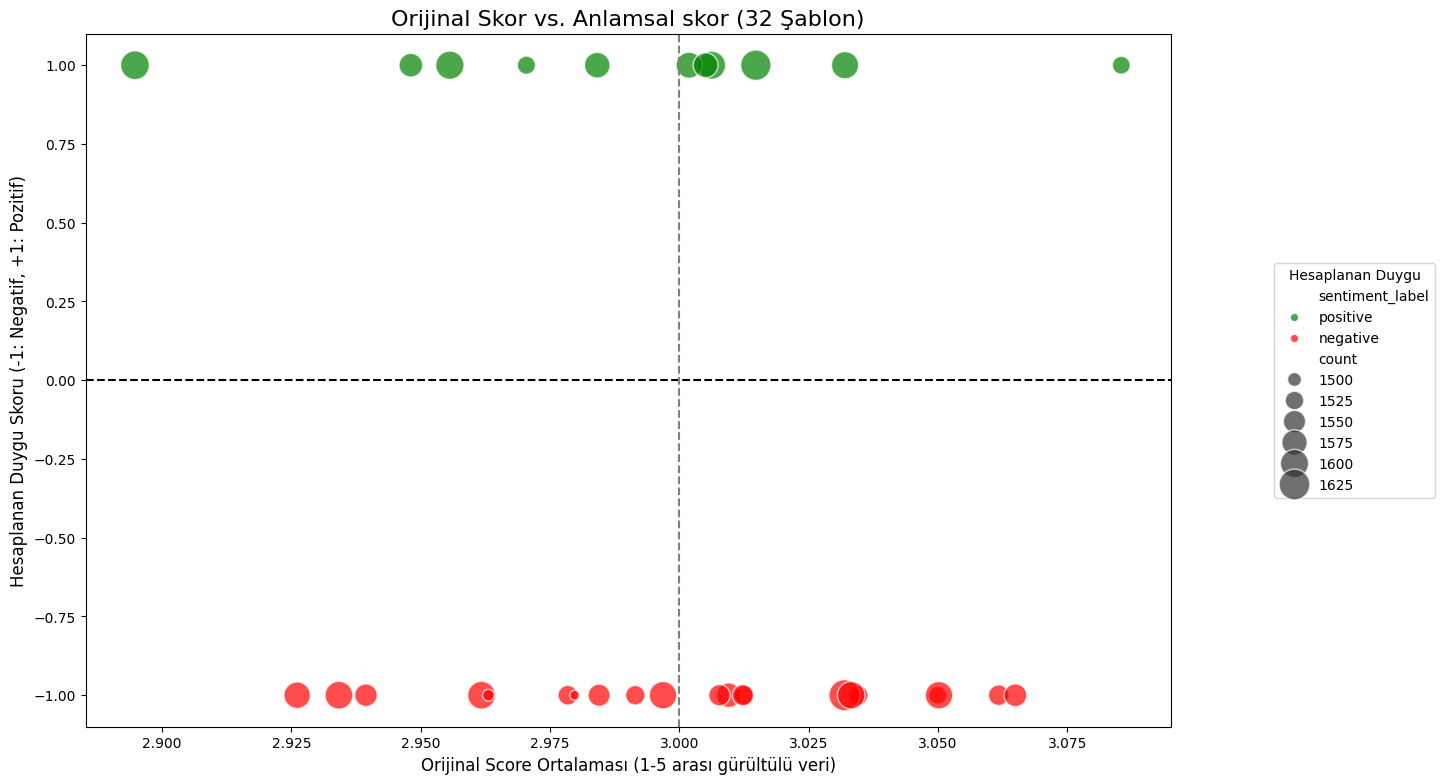

In [36]:
plt.figure(figsize=(14, 9))
# Scatterplot 
# 'size' ile hacmi, 'hue' ile duygu kategorisini gösteriyoruz
scatterplot = sns.scatterplot(
    data=df_templates,
    x='avg_score',            # Orijinal Skor
    y='sentiment_score',      # Bizim Hesapladığımız (Anlamsal) Skor
    hue='sentiment_label',
    size='count',
    sizes=(50, 500),
    palette={"positive": "g", "negative": "r", "neutral": "b"},
    alpha=0.7
)

plt.title('Orijinal Skor vs. Anlamsal skor (32 Şablon)', fontsize=16)
plt.xlabel('Orijinal Score Ortalaması (1-5 arası gürültülü veri)', fontsize=12)
plt.ylabel('Hesaplanan Duygu Skoru (-1: Negatif, +1: Pozitif)', fontsize=12)
plt.legend(title='Hesaplanan Duygu', loc='center right', bbox_to_anchor=(1.25, 0.5))

# Referans çizgileri ekleyelim
plt.axhline(0, color='black', linestyle='--') # Nötr (Anlamsal)
plt.axvline(3, color='grey', linestyle='--')  # Nötr (Gürültülü Ortalama)
plt.show()

# VERİ SETİ SCORE YAPISI

In [89]:
df['Feedback'].unique()

array(['Araç stokları çok sınırlıydı.', 'Destek ekibi ulaşılması zordu.',
       'Destek ekibi beklediğimden iyiydi.',
       'Araç bulunurluğu beklediğimden kötüydü.',
       'Krediye ulaşmak çok kolay oldu.',
       'Krediye ulaşmak beklediğimden kolaydı.',
       'Destek ekibi süreci hızlandırdı.', 'Destek ekibi profesyoneldi.',
       'Kredi başvurusu reddedildi, sebebi açıklanmadı.',
       'Kredi faiz oranları makul seviyedeydi.',
       'Krediye ulaşmak için şubeye gitmem gerekti.',
       'Kredi şartları açık ve anlaşılırdı.',
       'Araç bulmakta hiç zorlanmadım.',
       'İstediğim model mevcut değildi.',
       'Aradığım aracı hemen bulabildim.',
       'Krediye ulaşmak için müşteri hizmetleri yardımcı oldu.',
       'Kredi geri ödeme planı uygundu.',
       'Krediye ulaşmak için fazla belge istendi.',
       'Destek ekibi sorunumu çözdü.',
       'Kredi başvurum hızlıca onaylandı.',
       'Krediye ulaşmak için online başvuru yeterliydi.',
       'Destek ekibi tüm soruları

In [92]:
print(df[df['Feedback'] == 'Destek ekibi yetersiz bilgi verdi.']['Score'].describe())

count    1552.000000
mean        2.939433
std         1.435101
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Score, dtype: float64


In [93]:
print(df[df['Feedback'] == 'Destek ekibi sorunumu çözdü.']['Score'].describe())

count    1531.000000
mean        2.991509
std         1.444143
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Score, dtype: float64
